# Access to the endpoint and data sources of Covid-on-the-Web dataset
#### maintaned by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstartes how to access and query Covid-on-the-Web RDF dataset. The dataset describes named entities identified in the scholarly articles of the [COVID-19 Open Research Dataset (CORD-19)](https://pages.semanticscholar.org/coronavirus-research), a resource of over 47,000 articles about COVID-19 and the coronavirus family of viruses.

The full description of the dataset can be found here: https://github.com/Wimmics/CovidOnTheWeb

You can query the dataset from our Virtuoso endpoint: https://covidontheweb.inria.fr/sparql.

#### __Cite this work__
When including Covid-on-the-Web data in a publication or redistribution, please cite the dataset as follows:

Wimmics Research Team. Covid-on-the-Web Dataset. University Côte d'Azur, Inria, CNRS. 2020. Retrieved from https://github.com/Wimmics/CovidOnTheWeb.

In [1]:
R.Version()$version

[1] "R version 3.6.1 (2019-07-05)"

In [21]:
options(warn=-1)

install.packages("SPARQL")
library(SPARQL)

### Define dataset endpoint for the SPARQL data access. 

In [7]:
endpoint <- "https://covidontheweb.inria.fr/sparql"
options <- NULL

### Define prefixes to abbreviare namespaces. 
The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

In [8]:
sparql_prefix <- '
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl:    <http://www.w3.org/2002/07/owl#>
PREFIX xsd:    <http://www.w3.org/2001/XMLSchema#>

PREFIX bibo:   <http://purl.org/ontology/bibo/> 
PREFIX dce:    <http://purl.org/dc/elements/1.1/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX foaf:   <http://xmlns.com/foaf/0.1/>
PREFIX frbr:   <http://purl.org/vocab/frbr/core#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX prov:   <http://www.w3.org/ns/prov#>
PREFIX schema: <http://schema.org/>

prefix wd:     <http://www.wikidata.org/entity/>
prefix wdt:    <http://www.wikidata.org/prop/direct/>

PREFIX covid:   <http://ns.inria.fr/covid19/>
PREFIX covidpr: <http://ns.inria.fr/covid19/property/>
'

data_prefix <- c('covid','<http://ns.inria.fr/covid19/>', 
                'wd',   '<http://www.wikidata.org/entity/>',
                'wdt',  '<http://www.wikidata.org/prop/direct/>')

### Working with article metadata
Query dataset for the articles that mention the term *coronavirus* in their abstracts. 

In [10]:
query <- '
SELECT (group_concat(distinct ?name,"; ") AS ?authors)
       ?title 
       (year(?date) as ?year)
       ?pub
       ?url

WHERE {
    graph <http://ns.inria.fr/covid19/graph/articles>
    {
        ?doc a ?t;
            dce:creator ?name;
            dct:title ?title;
            schema:publication ?pub;
            schema:url ?url;
            dct:abstract [ rdf:value ?abs ].

        optional { ?doc dct:issued ?date }
        filter contains(?abs, "coronavirus")
    }
} 
group by ?doc ?title ?date ?pub ?url
having (count(distinct ?name) < 200)
order by desc(?date)

'

query <- paste(sparql_prefix, query)

res <- SPARQL(url= endpoint,
              query = query,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(res)))

[1] "Result rows: 14594"


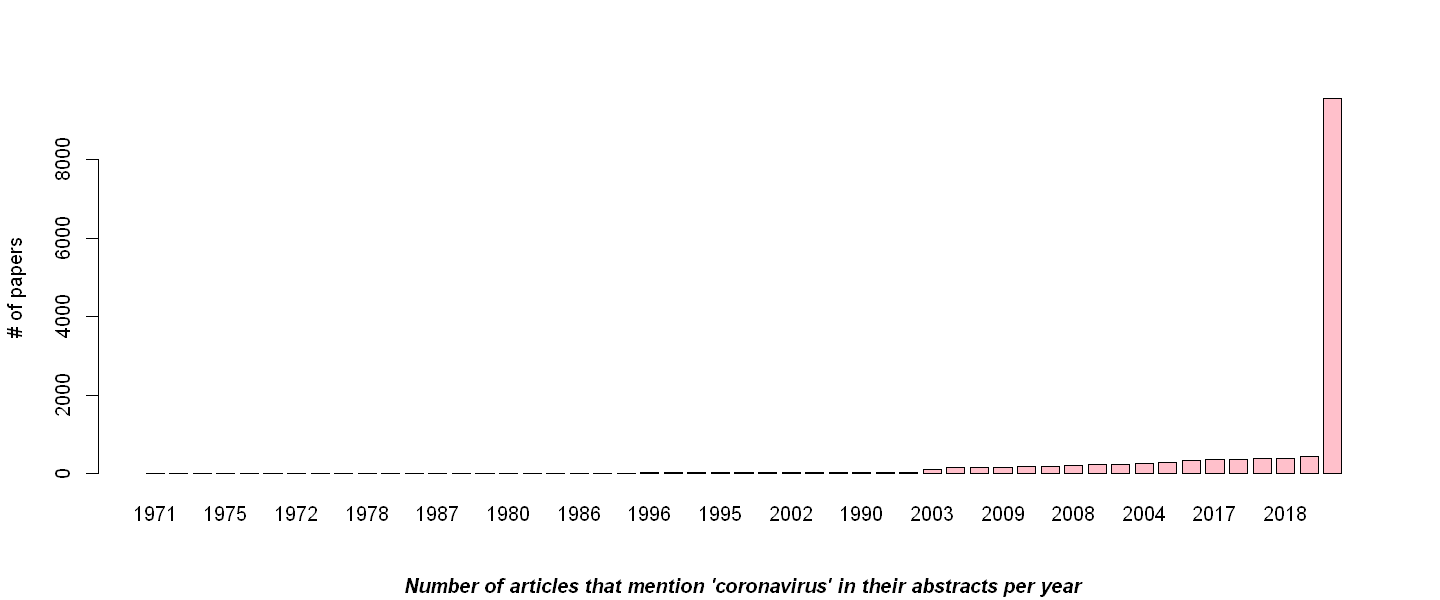

In [15]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)
options(repr.plot.align = 'center')

barplot(sort(table(res$year)),
        col="pink",
        space=0.3,
        ylab="# of papers",
        #log="y",
        sub="Number of articles that mention 'coronavirus' in their abstracts per year",
        font.sub=4)


### Working with article annotations
Query dataset for the articles refrencing *coronavirus* and forms of *cancer* at the same time

In [16]:
query_corona_vs_cancer = '
# wdt:P279 = subclass of 
# wdt:P31 = instance of
# wd:Q12078 = cancer
# wd:Q1134583 = coronavirus family

select distinct ?article ?dis1 ?dis1Label ?dis2 ?dis2Label #?dis2Subject

from <http://ns.inria.fr/covid19/graph/entityfishing>
from named <http://ns.inria.fr/covid19/graph/wikidata-named-entities-full>

where {
    # Look for 2 annotations of the same article with Wikidata URIs ?dis1 and ?dis2 

    ?annot1 schema:about ?article; oa:hasBody ?dis1.
    ?annot2 schema:about ?article; oa:hasBody ?dis2.
 
    graph <http://ns.inria.fr/covid19/graph/wikidata-named-entities-full>
    {
      ?entity1 rdfs:label "cancer"@en. # ?entity1 is wd:Q12078
      
      { ?dis1 rdfs:label ?dis1Label.
        filter (?dis1 = ?entity1) } # ?dis1 is "cancer"

      UNION

      { ?dis1 wdt:P279 ?entity1;
              rdfs:label ?dis1Label. }  # ?dis1 is a subclass of "cancer" (at any depth)

      UNION

      { ?dis1 wdt:P31 ?entity1; 
              rdfs:label ?dis1Label. }  # ?dis1 is an instance of "cancer" or a subclass



      ?entity2 rdfs:label "Coronaviridae"@en. # ?entity2 is wd:Q1134583

      { ?dis2 rdfs:label ?dis2Label. 
      filter (?dis2 = ?entity2) }

      UNION

      { ?dis2 wdt:P279 ?entity2;
              rdfs:label ?dis2Label. } # ?dis2 is a subclass of "Coronaviridae" (at any depth)

      UNION

      { ?dis2 wdt:P31 ?entity2; 
              rdfs:label ?dis2Label. }  # ?dis2 is an instance of "Coronaviridae" or a subclass

    }

    
}
order by ?dis1 ?dis2
limit 1000
'

query_corona_vs_cancer <- paste(sparql_prefix, query_corona_vs_cancer)

res <- SPARQL(url= endpoint,
              query = query_corona_vs_cancer,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(res)))

[1] "Result rows: 543"


In [17]:
# remove label decorations
res <- data.frame(lapply(res, function(x) {
                  gsub("@en", "", x)
              }))
res <- data.frame(lapply(res, function(x) {
                  gsub("\"", "", x)
              }))

### Visualize query results in different ways
Plot hierarchically-clustered heatmap

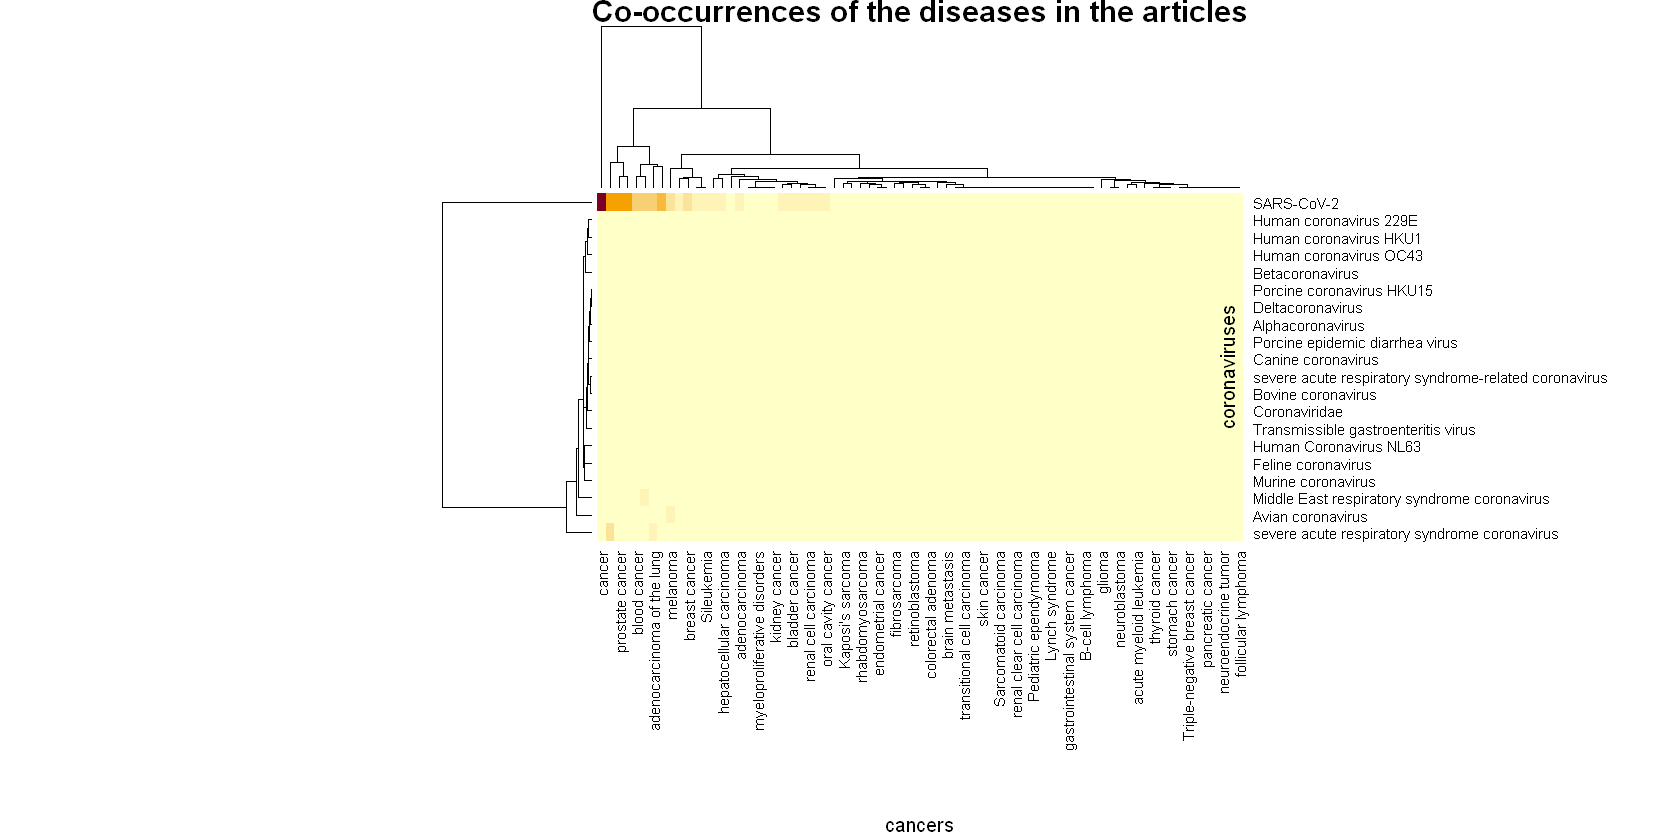

In [23]:
options(repr.plot.width = 14)
options(repr.plot.height = 7)
options(repr.plot.align = 'left')

hm <- table(res[, c('dis2Label','dis1Label')])
hm <- as.matrix(hm)

heatmap(hm,  margins = c(15,0), #Rowv = NA, Colv = NA,
        col = hcl.colors(12, "YlOrRd", rev = TRUE), 
        scale="none", 
        cexCol=0.9,
        cexRow = 0.9,
        main="Co-occurrences of the diseases in the articles",
        xlab="cancers", 
        ylab="coronaviruses")

Plot heatmap with ggplot

In [20]:
options(warn=-1)

library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


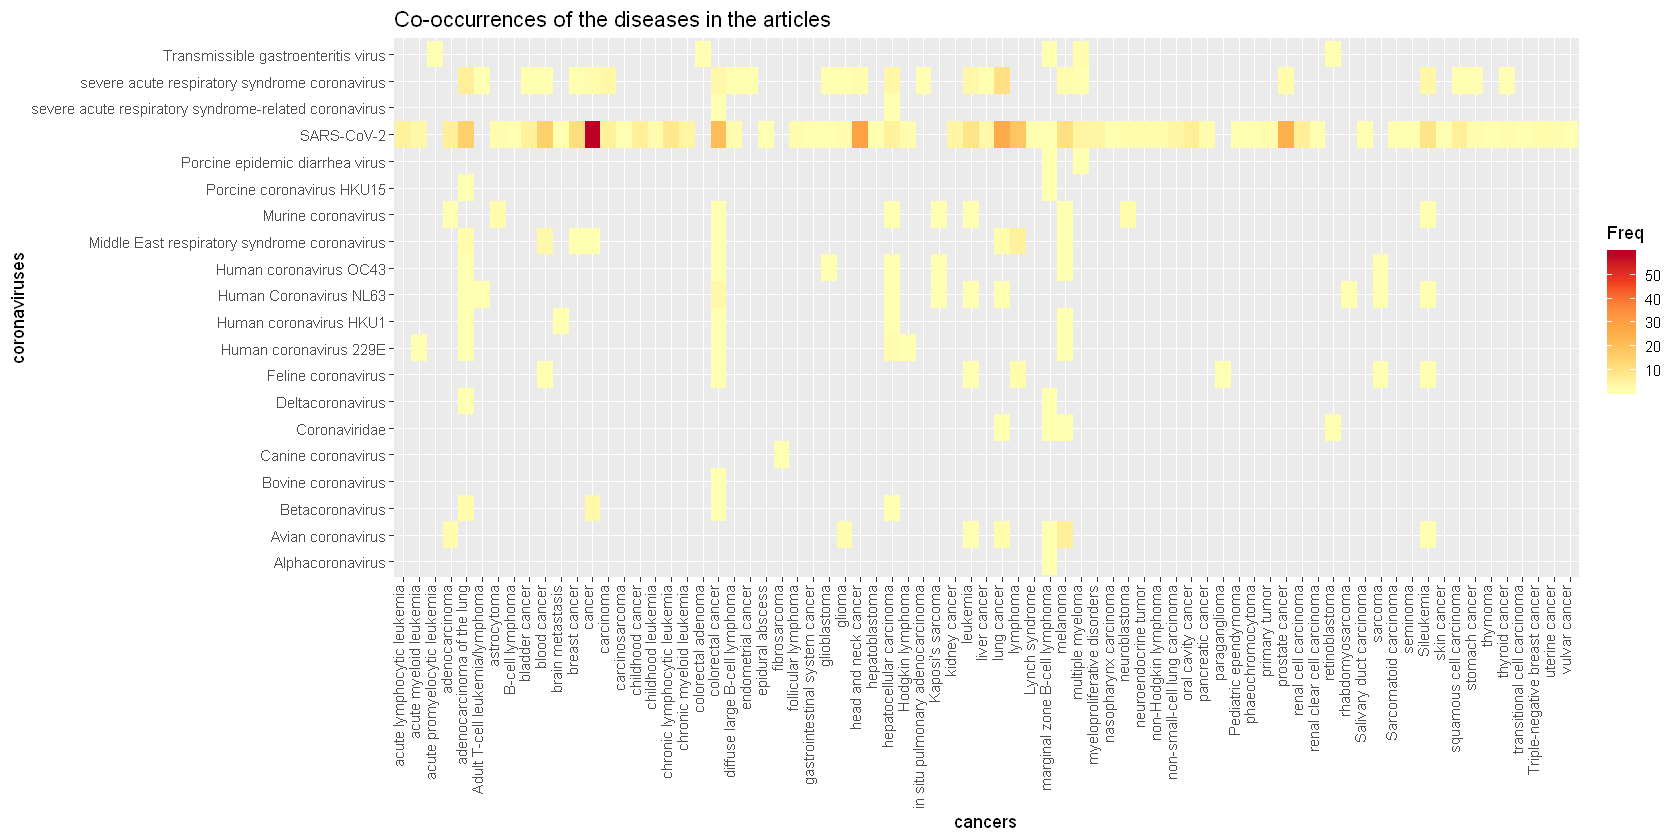

In [24]:
counts <- table(res[, c('dis2Label','dis1Label')])
counts <- as.data.frame(counts)
counts <- counts[counts$Freq > 0, ]

ggplot(counts, aes(x=dis1Label, y=dis2Label, fill=Freq)) + 
       geom_tile() +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       scale_fill_distiller(palette = "YlOrRd", direction = 1) +
       ggtitle("Co-occurrences of the diseases in the articles") +
       xlab("cancers") + 
       ylab("coronaviruses")

Plot bubble chart

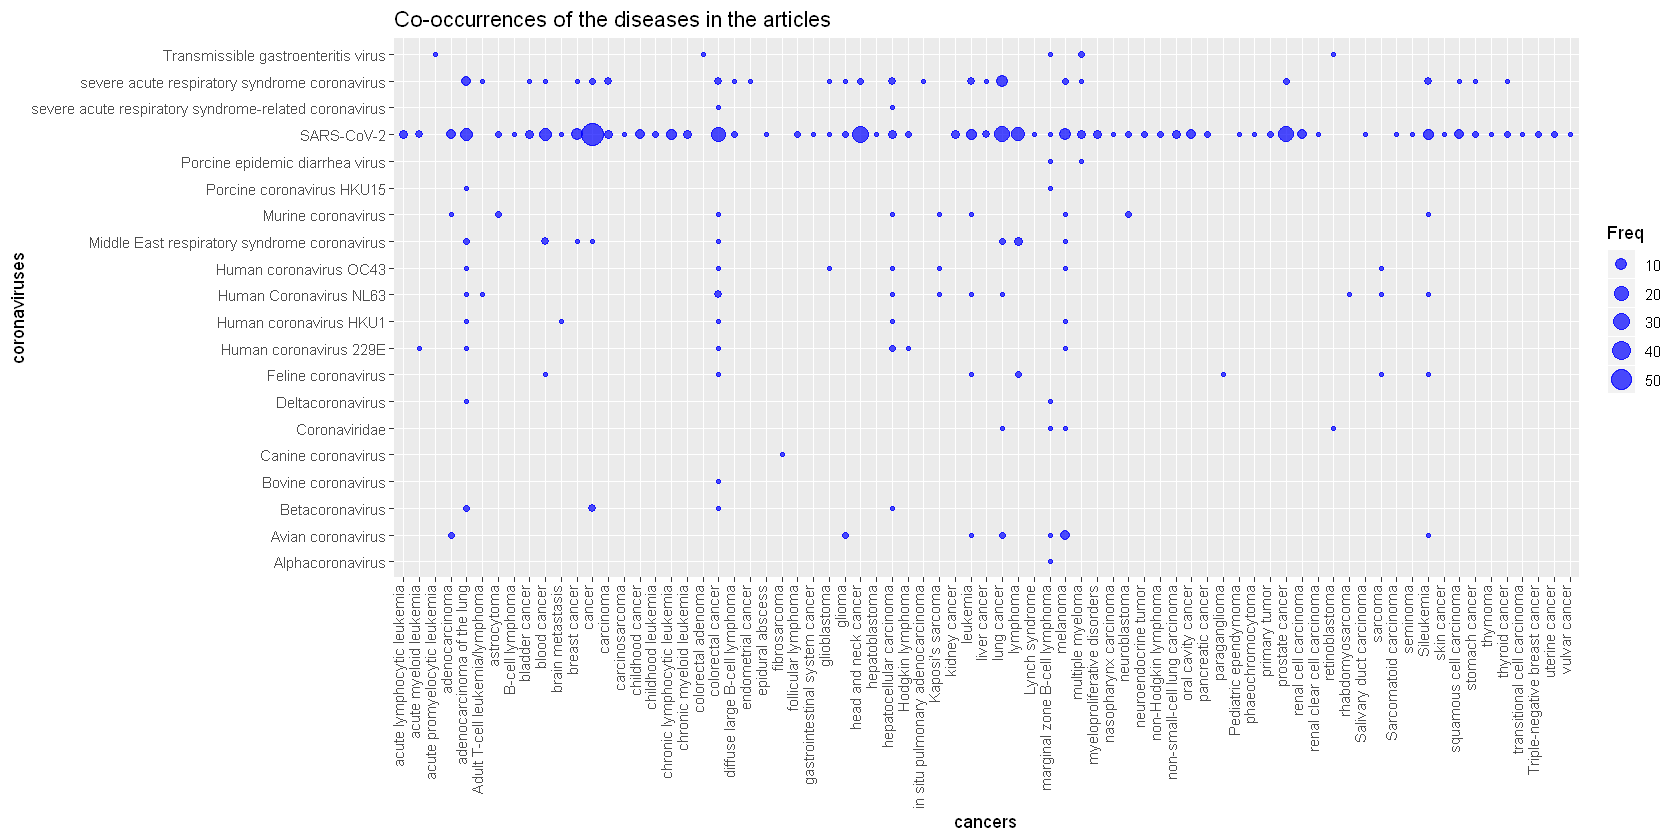

In [25]:
# Most basic bubble plot
ggplot(counts, aes(x=dis1Label, y=dis2Label, size = Freq)) +
       geom_point(alpha=0.7, color='blue') +
       theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
       ggtitle("Co-occurrences of the diseases in the articles") +
       xlab("cancers") + 
       ylab("coronaviruses") 

Plot stacked bar chart with default colors

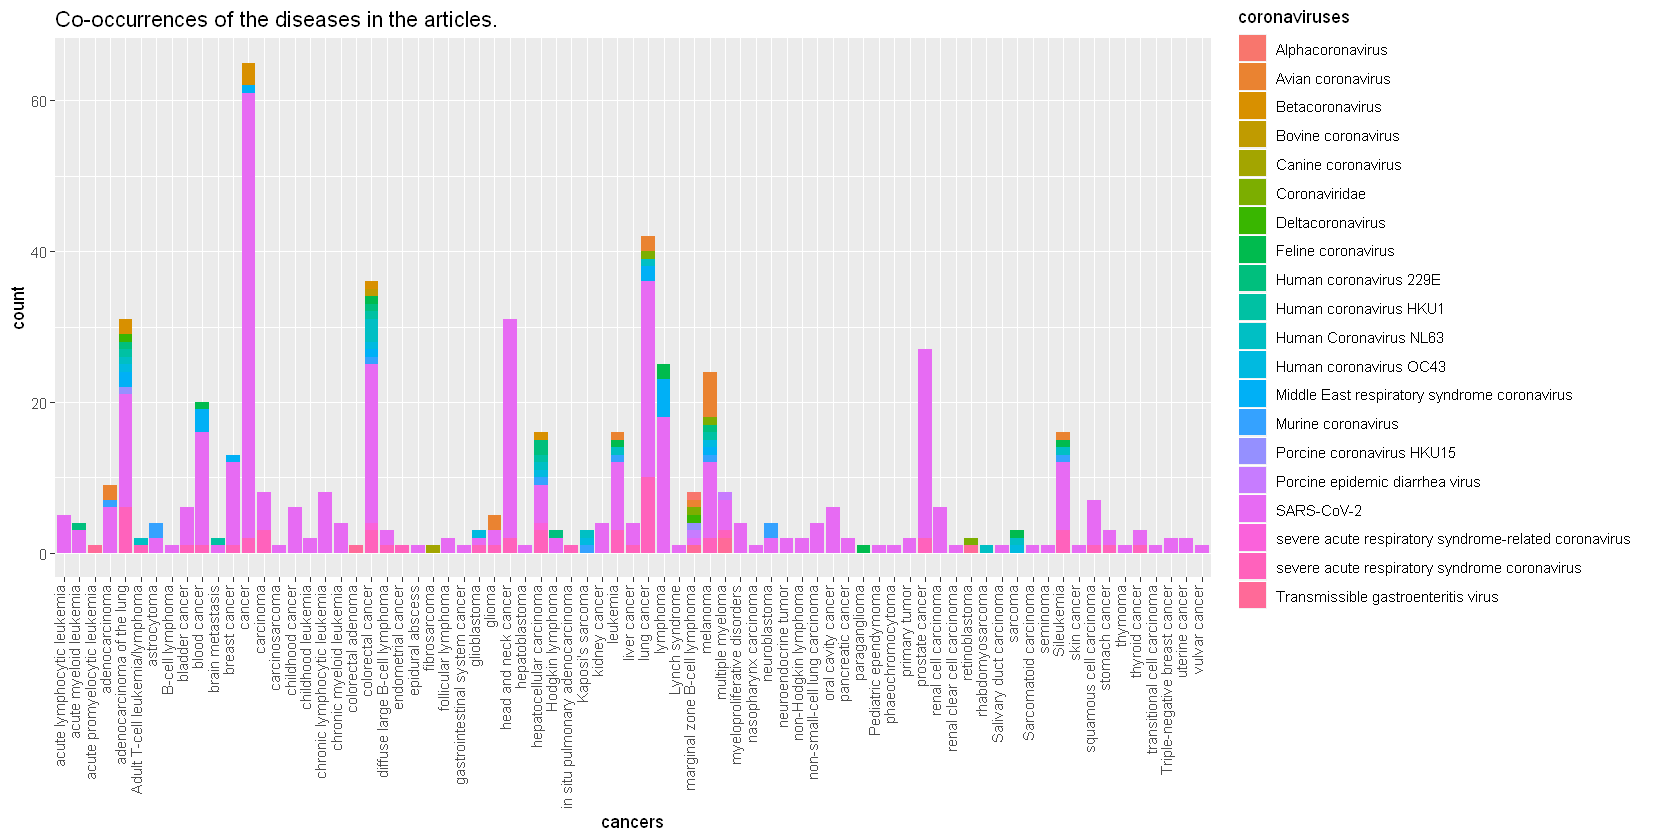

In [26]:
ggplot(res, 
       aes(x = dis1Label, 
           fill = dis2Label)) + 
  geom_bar(position = "stack") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
  ggtitle("Co-occurrences of the diseases in the articles.") +
  xlab("cancers") + 
  ylab("count") +
  labs(fill = "coronaviruses")

Plot stacked bar chart with default colors

In [27]:
# use RColorBrewer for custom coloring
library(RColorBrewer)

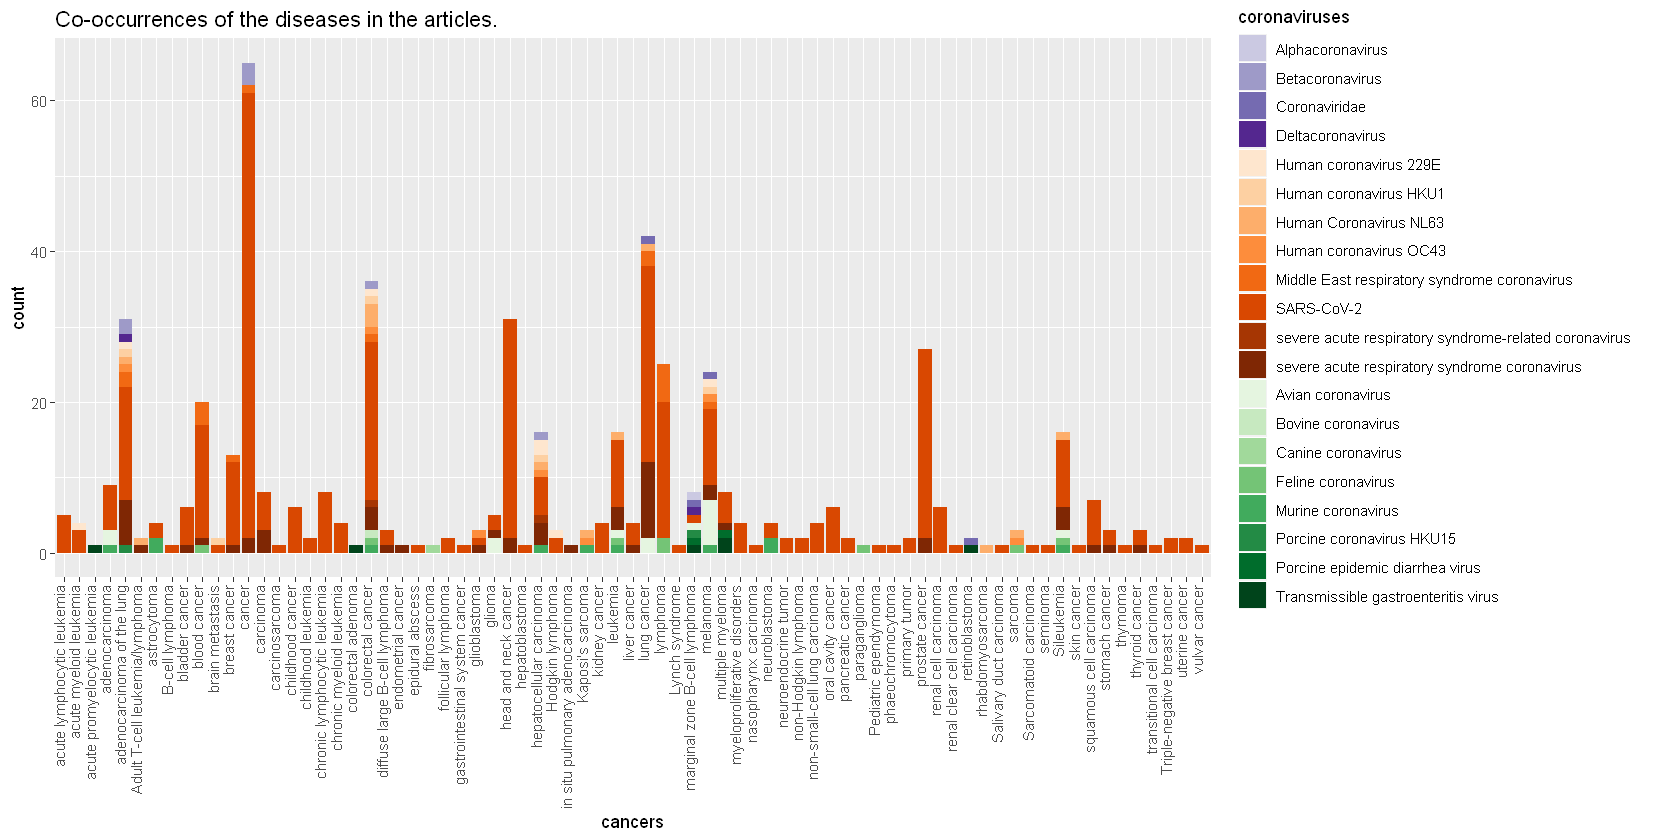

In [38]:
# Manually group coronaviruses in 3 groups (general(1), human(2), animal(3)) for reordering
res$group <- rep(1, nrow(res))
res$group[grep('SARS-CoV-2', res$dis2Label )] <- 2
res$group[grep('Human', res$dis2Label )] <- 2
res$group[grep('severe acute', res$dis2Label )] <- 2
res$group[grep('Middle', res$dis2Label )] <- 2
res$group[grep('Avian', res$dis2Label )] <- 3
res$group[grep('Bovine', res$dis2Label )] <- 3
res$group[grep('Canine', res$dis2Label )] <- 3
res$group[grep('Feline', res$dis2Label )] <- 3
res$group[grep('Murine', res$dis2Label )] <- 3
res$group[grep('Porcine', res$dis2Label )] <- 3
res$group[grep('Transmissible', res$dis2Label )] <- 3


# Manually choose colors for coronaviruses (shades of purple for general (1), blues for humans(2), and greens for animals(3))
# select one color over and shift the palete to avoid the very light colors

general_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 1])) +1 , 'Purples')[-1]
names(general_colors) <- sort(unique(res$dis2Label[res$group == 1]))

human_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 2])) +1 , 'Oranges')[-1]
names(human_colors) <- sort(unique(res$dis2Label[res$group == 2]))

animal_colors <- brewer.pal(length(unique(res$dis2Label[res$group == 3])) +1 , 'Greens')[-1]
names(animal_colors) <- sort(unique(res$dis2Label[res$group == 3]))

ggplot(res, 
       aes(x = dis1Label, fill = reorder(dis2Label , group))) + 
      geom_bar(position = "stack") +
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
      scale_fill_manual(name = "coronaviruses", values = c(general_colors, human_colors, animal_colors)) +
      ggtitle("Co-occurrences of the diseases in the articles.") +
      xlab("cancers") + 
      ylab("count") +
      labs(fill = "coronaviruses")

Plot barplot for grouped diseases

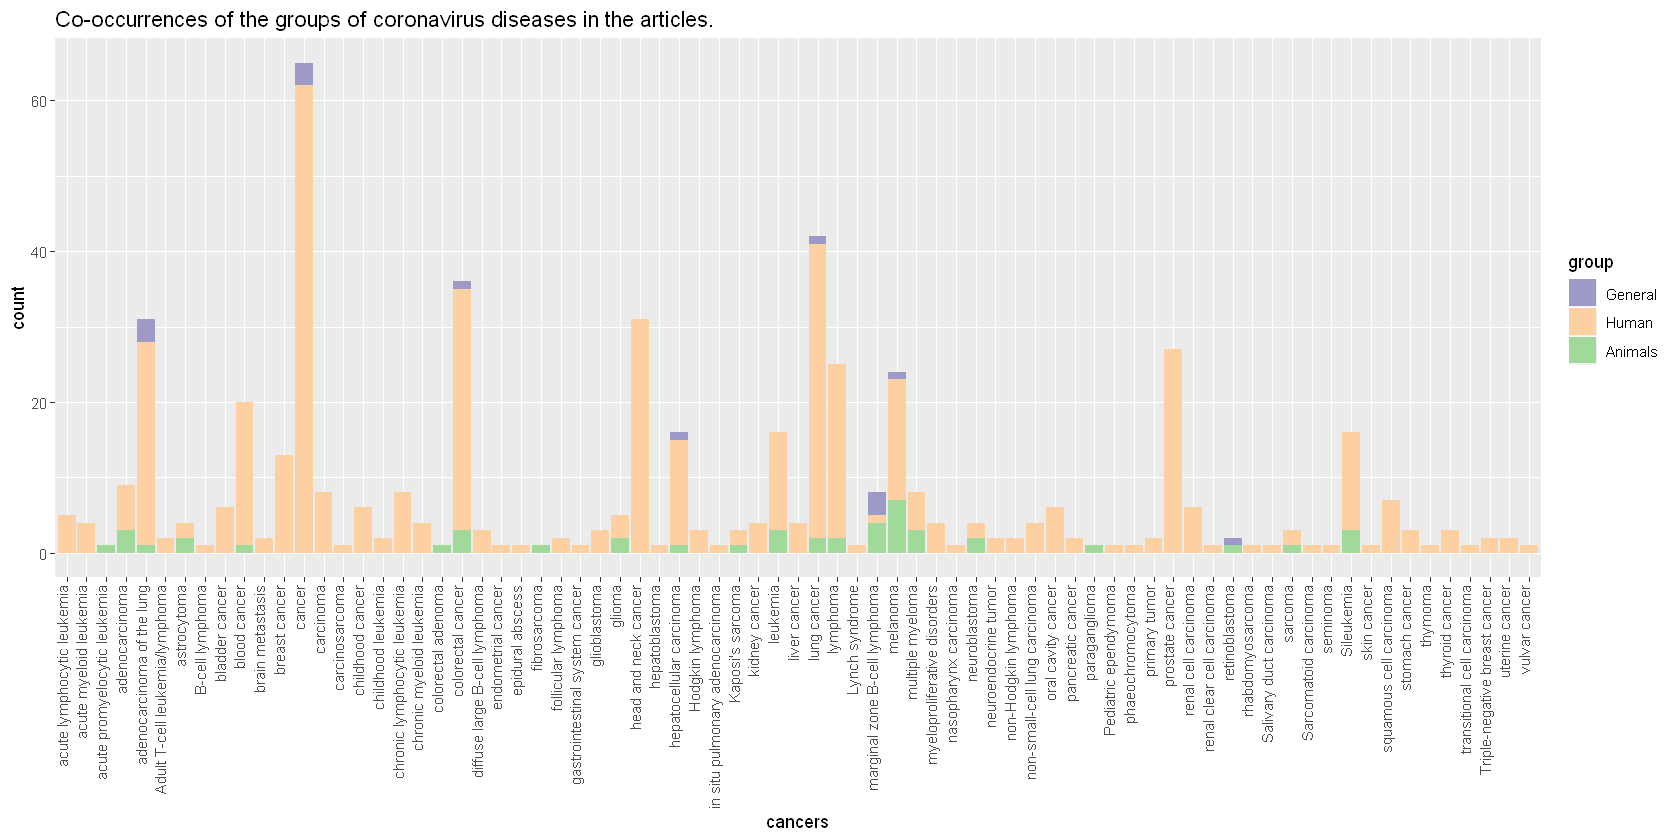

In [39]:
#group_colors = c('plum', 'skyblue', ' green')
group_colors = c (general_colors[2], human_colors[2], animal_colors[3])
names(group_colors) <- c("General", "Human", "Animals")
                 
ggplot(res, 
       aes(x = dis1Label, 
           fill =  factor(group, levels = c(1, 2, 3), labels = c("General", "Human", "Animals")))) + 
  geom_bar(position = "stack") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0)) +
  scale_fill_manual(name = "group", values = group_colors) +
  ggtitle("Co-occurrences of the groups of coronavirus diseases in the articles.") +
  xlab("cancers") + 
  ylab("count") +
  labs(fill = "coronaviruses")